[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


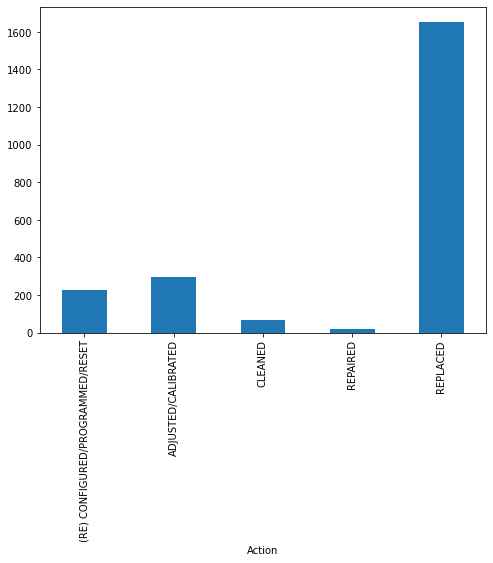

In [1]:
import pandas as pd
import numpy as np
import re
import numpy
import nltk
import string
from io import StringIO
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim import models
import gensim

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams

from nltk.tokenize import word_tokenize
from nltk import punkt
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import pandas.testing as tm
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

from collections import defaultdict
from collections import  Counter
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import preprocessing
from elasticsearch import Elasticsearch
from pandasticsearch import DataFrame


data = pd.read_csv('../file/data_dropna.csv')


nltk.download('stopwords')

stop = set(stopwords.words('english'))


def data_text_cleaning(x):
    only_english = re.sub('[^a-zA-Z]', ' ', x)
    no_capitals = only_english.lower().split()
    stops = set(stopwords.words('english'))
    
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer = nltk.stem.SnowballStemmer('english') #형태소 분석기
    stemmer_words = [stemmer.stem(word) for word in no_stops] #어간 추출
    wordnet_lemmatizer = WordNetLemmatizer() #표제어추출
    words = [wordnet_lemmatizer.lemmatize(w) for w in stemmer_words]
    

    return words

nltk.download('wordnet')
nltk.download('omw-1.4')

data['resolutiontext1'] = data['resolutiontext'].apply(lambda x: data_text_cleaning(x))
data['resolutiontext1'] = data['resolutiontext1'].apply(lambda x: " ".join(str(c) for c in x))

data['servicetext1'] = data['servicetext'].apply(lambda x: data_text_cleaning(str(x)))
data['servicetext1'] = data['servicetext1'].apply(lambda x: " ".join(str(c) for c in x))

data['escalationtext1'] = data['escalationtext'].apply(lambda x: data_text_cleaning(str(x)))
data['escalationtext1'] = data['escalationtext1'].apply(lambda x: " ".join(str(c) for c in x))

data_list = []
data_list.append(data[(data['Action']=='(RE) CONFIGURED/PROGRAMMED/RESET')&
     (data["resolutiontext1"].str.contains("adjust|reset|setup|configur|recov|reboot|initi|pwer|cycl|reimg|firmwar", 
                                          na=False))])
data_list.append(data[(data['Action']=='ADJUSTED/CALIBRATED')&
     (data["resolutiontext1"].str.contains("adjust|level|reteach|calibr|algin|recalibr", 
                                          na=False))])
data_list.append(data[(data['Action']=='CLEANED')&
     (data["resolutiontext1"].str.contains("CLEAN|clean|particl", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPAIRED')&
     (data["resolutiontext1"].str.contains("REPAIR|repair", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPLACED WITH SAME PART')&
     (data["resolutiontext1"].str.contains("replac", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPLACED WITH DIFFERENT PART')&
     (data["resolutiontext1"].str.contains("replac", 
                                          na=False))])
dfs = pd.concat(data_list, axis=0)

dfs.loc[dfs['Action']=='REPLACED WITH SAME PART','Action'] = 'REPLACED'
dfs.loc[dfs['Action']=='REPLACED WITH DIFFERENT PART','Action'] = 'REPLACED'
dfs = dfs.loc[dfs['Action']!='VERIFIED']
dfs = dfs.loc[dfs['Escalation Reason']!='Part Number Needed']


dfs['category_id'] = dfs['Action'].factorize()[0]
category_id_df = dfs[['Action', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)

encoder = LabelEncoder()
encoder.fit(dfs.Action)
dfs['Action_label'] = encoder.transform(dfs.Action)


#dfs check
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

dfs.groupby('Action').resolutiontext.count().plot.bar(ylim=0)
plt.show()






In [2]:
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]

patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    clean = bytes(text.lower(), encoding="utf-8")
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    clean = clean.replace(b"fix", b" ")
    clean = clean.replace(b"part", b" ")
    clean = clean.replace(b"number", b" ")
     
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    
    clean = re.sub(b"\d+", b" ", clean)
    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))


def get_indicators_and_clean_comments(df):
    df["ant_slash_n"] = df["resolutiontext"].apply(lambda x: count_regexp_occ(r"\n", x))
    df["raw_word_len"] = df["resolutiontext"].apply(lambda x: len(x.split()))
    df["raw_char_len"] = df["resolutiontext"].apply(lambda x: len(x))
    df["nb_upper"] = df["resolutiontext"].apply(lambda x: count_regexp_occ(r"[A-Z]", x))
    df["clean_comment"] = df["resolutiontext"].apply(lambda x: prepare_for_char_n_gram(x))
    df["clean_comment1"] = df["escalationtext"].astype(str).apply(lambda x: prepare_for_char_n_gram(x))
    df["clean_comment2"] = df["servicetext"].astype(str).apply(lambda x: prepare_for_char_n_gram(x))

get_indicators_and_clean_comments(dfs)
num_features = ["ant_slash_n","raw_word_len","raw_char_len","nb_upper"]
skl = MinMaxScaler()
#희소행렬
dfs_num_features = csr_matrix(skl.fit_transform(dfs[num_features]))

text1 = dfs.clean_comment.values.astype('U')
Action1 = dfs.Action.values.astype('U')
###
# min_df: 단어가 포함된 문서의 수
# analyzer: word -> 단어 기준
# ngram_range: 단어 묶음 
#   (1,1) 1개~ 1개묶음
# max_features: 최대 행렬의 열 
###
tfidf = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1,1), max_features=280)
features = tfidf.fit_transform(text1).toarray()
labels = dfs.category_id
features.shape

N = 2
#chi2 가설검정
for Action, category_id in sorted(category_to_id.items()):
    #카이제곱: 연관성유무
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    # print("# '{}':".format(Action))
    # print(' . Most correlated unigrams:\n. {}'.format('\n. '.join(unigrams[-N:])))
    

    
    



In [3]:

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def build_dictionary(sentence):
    dictionary = {}
    for sent in sentence:
        pos_tags = nltk.pos_tag(word_tokenize(sent))
        for tag in pos_tags:
            value = tag[0]
            pos = tag[1]
            dictionary[value] = pos
    
    return dictionary
    
    
def data_text_cleaning(data):
    only_english = re.sub('[^a-zA-Z]', ' ', data)
    no_capitals = only_english.lower().split()
    # print(no_capitals)

    stops = set(stopwords.words('english'))
    no_stops = [word for word in no_capitals if not word in stops]

    stemmer = nltk.stem.SnowballStemmer('english')
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    
    wordnet_lemmatizer = WordNetLemmatizer()

    li = []

    words = [wordnet_lemmatizer.lemmatize(w) for w in stemmer_words]
    li.append(" ".join(str(x) for x in words))
    pos_dict = build_dictionary(li)

    nouns = [n for n, tag in pos_dict.items() if tag in ['NN', 'NNP']]
    verbs = [n for n, tag in pos_dict.items() if tag in ['JJ', 'VBZ', 'VB']]
    # print(nouns)
    # print('========================')
    # print(verbs)
    return [nouns, verbs]
    

nltk.download('wordnet')
a = dfs.resolutiontext.apply(lambda x: data_text_cleaning(x)[0])
b = dfs.resolutiontext.apply(lambda x: data_text_cleaning(x)[1])

dfs['nouns'] = a
dfs['verbs'] = b





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


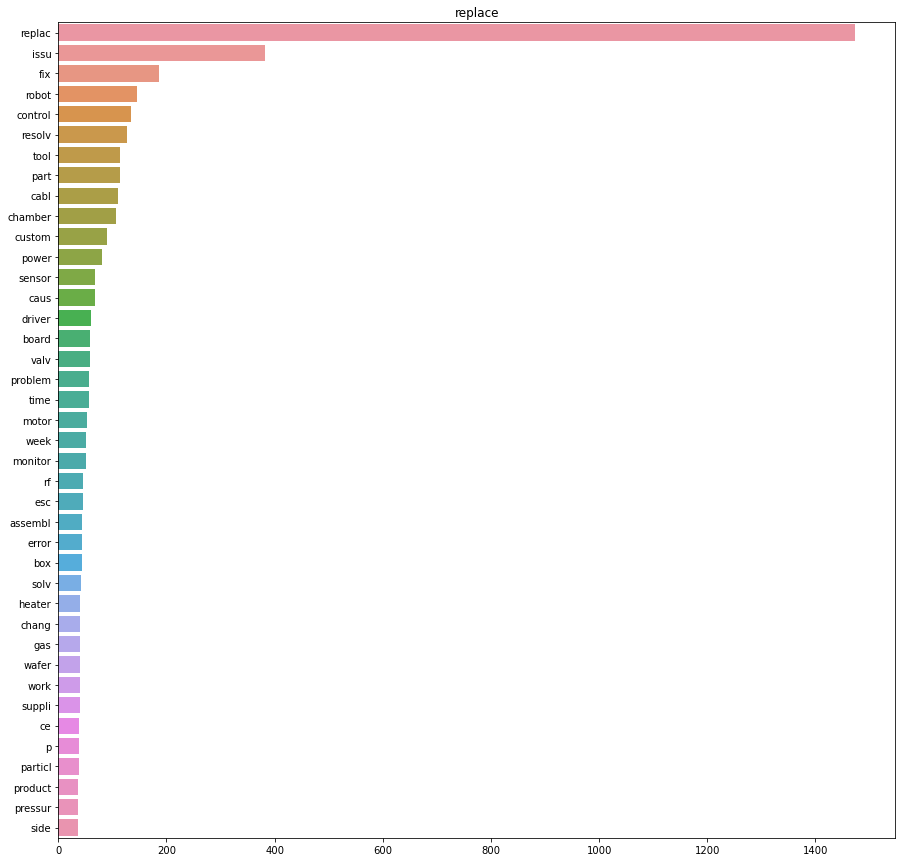

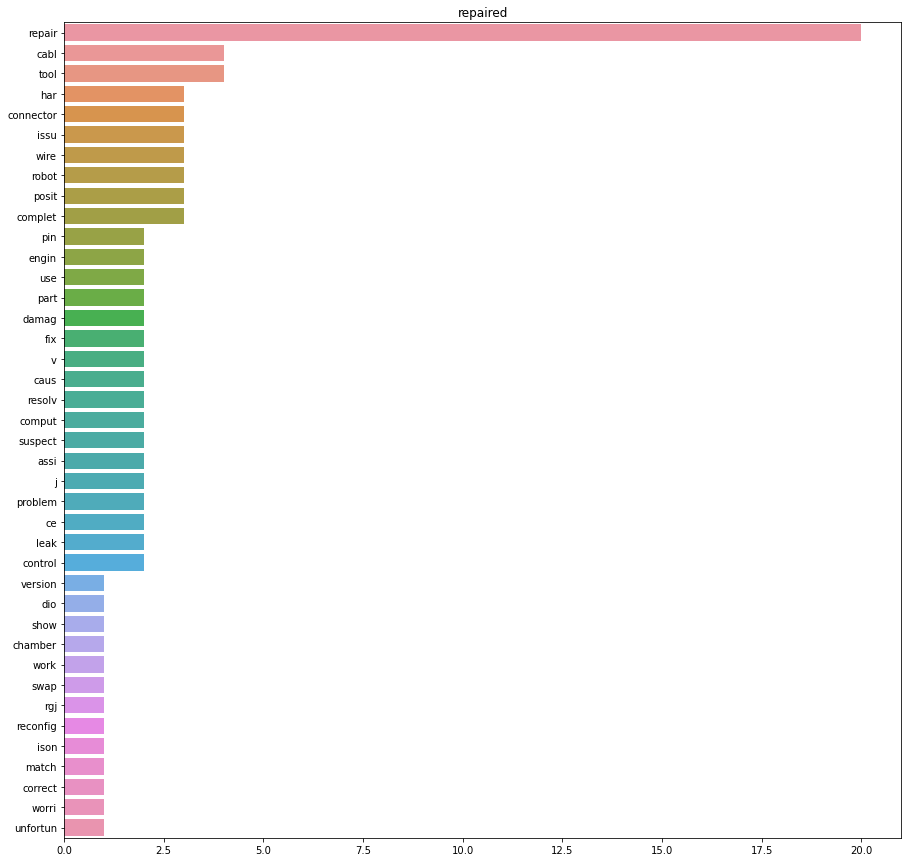

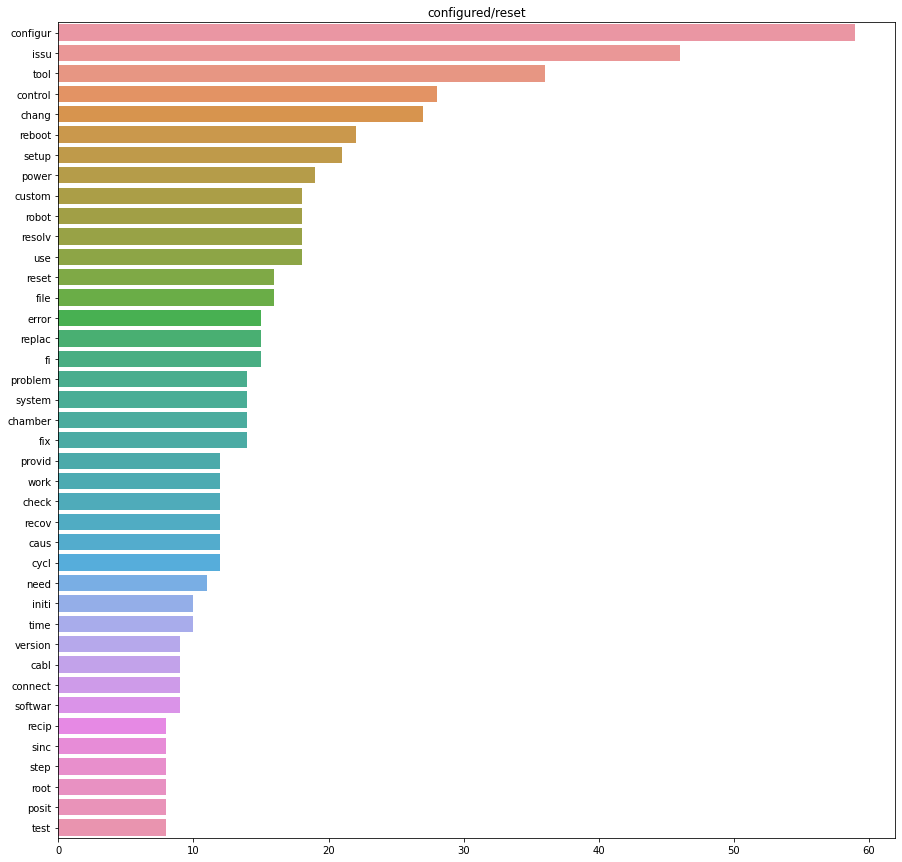

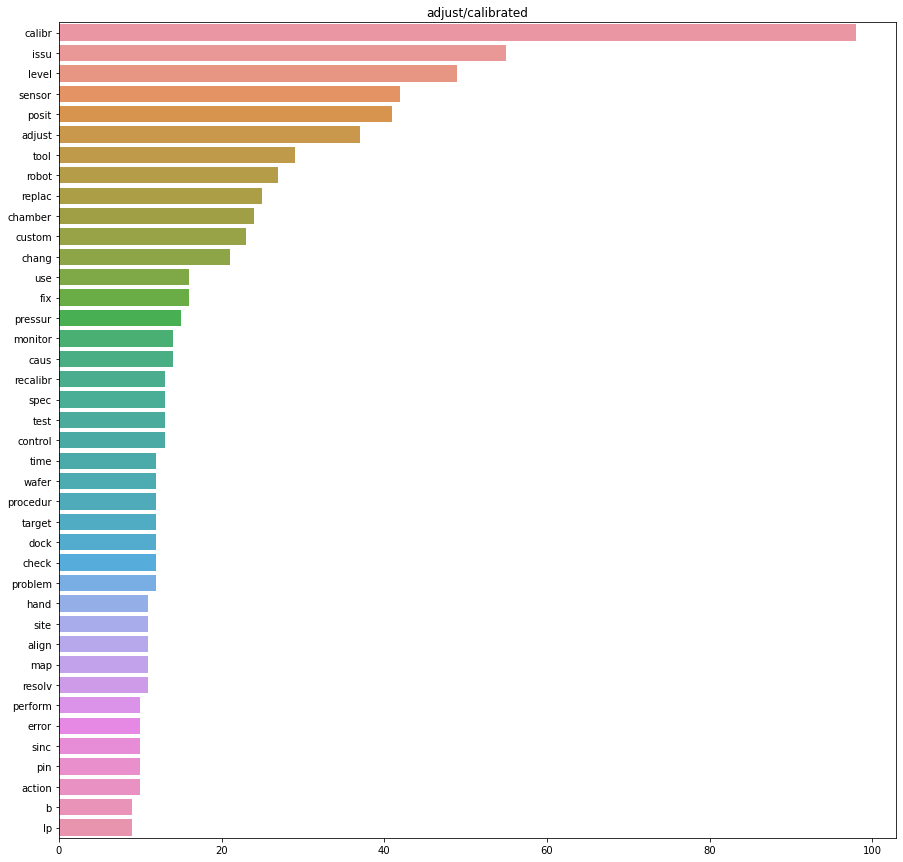

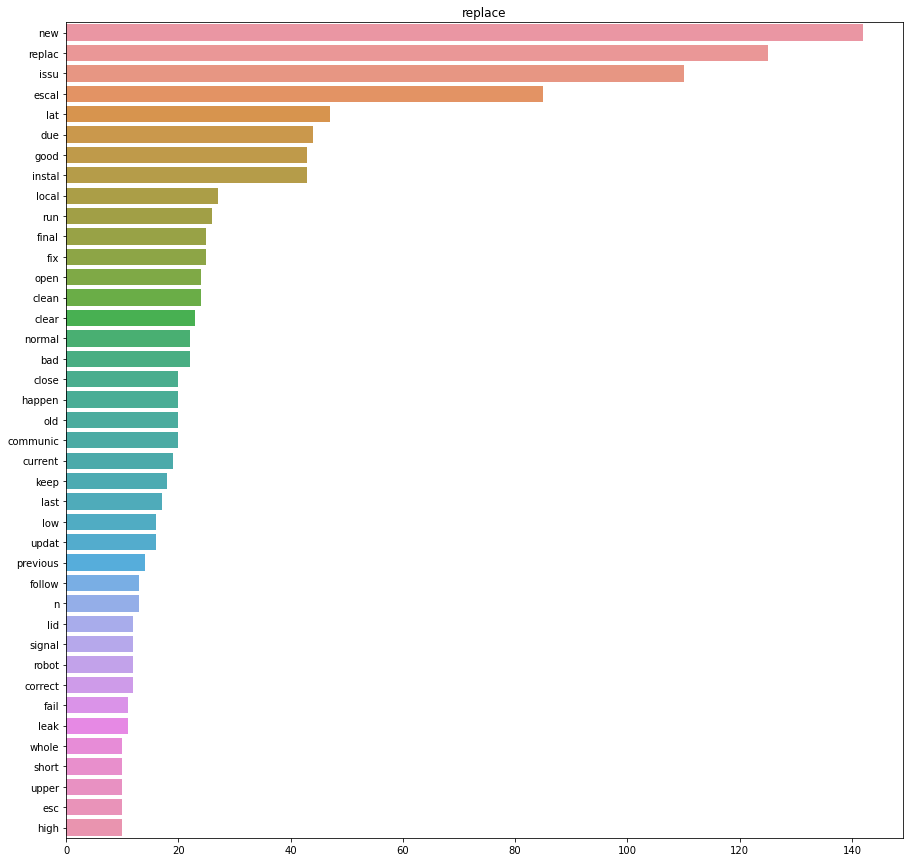

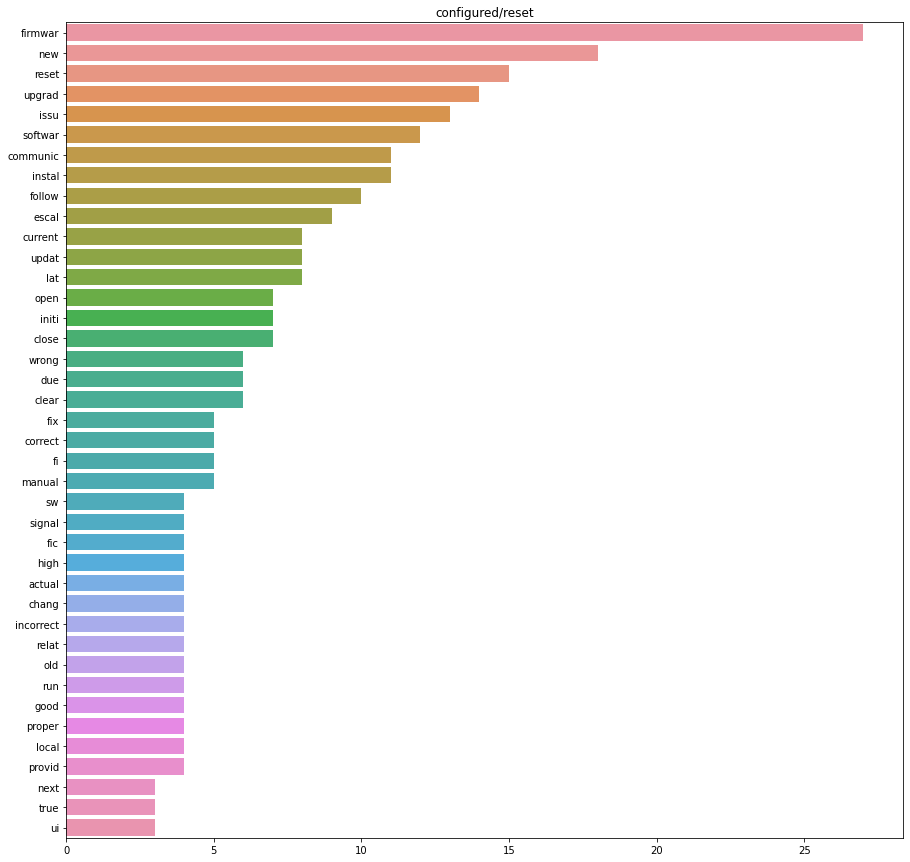

In [4]:
def create_corpus(target, text):
    corpus=[]
    for x in dfs[dfs['Action']==target][text]:
        for i in x:
            corpus.append(i)
    
    return corpus

dfs.Action.unique()

corpus=create_corpus('REPLACED','nouns')
# print(corpus)
counter=Counter(corpus)
# print(counter)
most=counter.most_common()
# print(most)

x=[]
y=[]
for word, count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,15))
sns.barplot(x=y, y=x)
plt.title('replace')
plt.show()


corpus=create_corpus('REPAIRED', 'nouns')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]

for word, count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,15))
sns.barplot(x=y,y=x)
plt.title('repaired')
plt.show()

corpus=create_corpus('(RE) CONFIGURED/PROGRAMMED/RESET', 'nouns')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]

for word, count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,15))
sns.barplot(x=y,y=x)
plt.title('configured/reset')
plt.show()

corpus=create_corpus('ADJUSTED/CALIBRATED', 'nouns')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]

for word, count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,15))
sns.barplot(x=y,y=x)
plt.title('adjust/calibrated')
plt.show()

corpus=create_corpus('REPLACED','verbs')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,15))
sns.barplot(x=y,y=x)
plt.title('replace')
plt.show()

corpus=create_corpus('(RE) CONFIGURED/PROGRAMMED/RESET', 'verbs')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,15))
sns.barplot(x=y,y=x)
plt.title('configured/reset')
plt.show()


In [5]:
'''
tfidf/word2vec/glove 각각 xgboost로 비교
'''
final_result = []

for i,name in zip(['clean_comment', 'clean_comment1','clean_comment2'], ['resolutiontext', 'escalationtext','servicetext']):
  tfidf_transformer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1,1),max_features=280)
  X = tfidf_transformer.fit_transform(dfs[i]).toarray()
  
  
  X1 = pd.DataFrame(X)
  X1['col1'] = dfs['raw_word_len']
  X1['col2'] = dfs['raw_char_len']
  X1['col3'] = dfs['nb_upper']
  X1 = X1.fillna(0)
  
  # print(X1.dtypes)
  y = dfs['Action_label'].values
  X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=0, stratify=y)

  rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
  svm = LinearSVC()
  nb = MultinomialNB()
  lg = LogisticRegression(random_state=0, max_iter=10000)
  parameters = {
        # 'n_estimators' : 300,
        'learning_rate' : 0.1,
        'eta': 0.3,  
        # 'silent': True,  # option for logging
        'objective': 'multi:softprob',  # error evaluation for multiclass tasks
        'num_class': 5,  # number of classes to predic
        'max_depth': 5,  # depth of the trees in the boosting process
        'eval_metric': 'mlogloss'
        }  
  num_round = 100

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)
  bst = xgb.train(parameters, dtrain, num_round)

  rf.fit(X_train, y_train)
  svm.fit(X_train, y_train)
  lg.fit(X_train, y_train)

  result=[]

  preds = bst.predict(dtest)
  preds_rf = rf.predict(X_test)
  preds_svm = svm.predict(X_test)
  preds_lg = lg.predict(X_test)

  # print(preds)
  # print('='*100,'@')
  # print(preds_rf)
  # print('='*100, 'rf')
  # print(preds_svm)
  # print('='*100, 'svm')
  # print(preds_lg)
  # print('='*100, 'lg')
  
  best_preds = np.asarray([np.argmax(line) for line in preds])
  result.append(accuracy_score(y_test, best_preds))
  result.append(accuracy_score(y_test, preds_rf))
  result.append(accuracy_score(y_test, preds_svm))
  result.append(accuracy_score(y_test, preds_lg))
  
  final_result.append(result)



c:\Users\User\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\User\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\User\anaconda3\envs\py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\User\anaconda3\envs\py38\lib\site-packages\sklearn\uti

In [6]:
print(final_result)
result_df = pd.DataFrame(final_result, columns=['xgboost','rf','svm','logistic'], index=['resolutiontext', 'escalationtext', 'servicetext'])


print('accuracy score')

result_df

[[0.9279411764705883, 0.7294117647058823, 0.875, 0.8735294117647059], [0.7176470588235294, 0.7294117647058823, 0.6985294117647058, 0.7294117647058823], [0.7308823529411764, 0.7294117647058823, 0.6147058823529412, 0.7382352941176471]]
accuracy score


,xgboost,rf,svm,logistic
resolutiontext,0.927941,0.729412,0.875000,0.873529
escalationtext,0.717647,0.729412,0.698529,0.729412
servicetext,0.730882,0.729412,0.614706,0.738235


In [7]:
stop_words = stopwords.words('english')
filepath = 'C:\\Users\\User\\Downloads\\archive\\glove.6B.100d.txt'

embeddings_index = {}

f = open(filepath, encoding='utf-8')
print(f)
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('found %s word vectors.' % len(embeddings_index))


    


<_io.TextIOWrapper name='C:\\Users\\User\\Downloads\\archive\\glove.6B.100d.txt' mode='r' encoding='utf-8'>


400000it [00:09, 40642.03it/s]

found 400000 word vectors.


In [8]:

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v **2).sum())


final_result = []

for i,name in zip(['clean_comment','clean_comment1','clean_comment2'],['resolutiontext','escalationtext','servicetext']):
    xtrain_glove = [sent2vec(x) for x in tqdm(dfs[i])]
    xtrain_glove = np.array(xtrain_glove)
    
    X1 = pd.DataFrame(xtrain_glove)
    X1 = X1.fillna(0)
    y = dfs['Action_label'].values
    X_train, X_test,y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=0, stratify=y)


    rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    svm = LinearSVC()
    lg = LogisticRegression(random_state=0)

    parameters = {
        # 'n_estimators' : 300,
        'learning_rate' : 0.1,
        'eta': 0.3,  
        # 'silent': True,  # option for logging
        'objective': 'multi:softprob',  # error evaluation for multiclass tasks
        'num_class': 5,  # number of classes to predic
        'max_depth': 5,  # depth of the trees in the boosting process
        'eval_metric': 'mlogloss'
        }  
    num_round = 100 

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    bst = xgb.train(parameters, dtrain, num_round)
    rf.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    lg.fit(X_train, y_train)

    result = []

    preds = bst.predict(dtest)
    preds_rf = rf.predict(X_test)
    preds_svm = svm.predict(X_test)
    preds_lg = lg.predict(X_test)
    
    best_preds = np.asarray([np.argmax(line) for line in preds])

    result.append(accuracy_score(y_test, best_preds))
    result.append(accuracy_score(y_test, preds_rf))
    result.append(accuracy_score(y_test, preds_svm))
    result.append(accuracy_score(y_test, preds_lg))

    final_result.append(result)

result_df = pd.DataFrame(final_result, columns = ['xgboost','rf','svm','logistic']
             , index = ['resolutiontext','escalationtext','servicetext'])

print('accuracy score')
result_df



100%|██████████| 2265/2265 [00:00<00:00, 2437.03it/s]


accuracy score


,xgboost,rf,svm,logistic
resolutiontext,0.830882,0.750000,0.857353,0.827941
escalationtext,0.733824,0.729412,0.723529,0.727941
servicetext,0.723529,0.729412,0.733824,0.730882


In [25]:
def create_corpus(df):
    corpus=[]
    for dt in tqdm(df['clean_comment']):
        words=[word.lower() for word in word_tokenize(dt) if((word.isalpha() == 1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus = create_corpus(dfs)


embedding_dict={}


with open (r'../glove.6B.100d.txt','r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:], 'float32')
        embedding_dict[word]=vectors
f.close()

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

dt_pad=pad_sequences(sequences,maxlen=MAX_LEN, truncating='post',padding='post')

word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))


num_words=len(word_index) + 1
embedding_matrix=np.zeros((num_words,100))


for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue

    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

model = Sequential()

embedding=Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
from tensorflow.keras.utils import to_categorical

y = to_categorical(dfs['category_id'])

# print(dt_pad)
X_train, X_test, y_train, y_test = train_test_split(dt_pad, y, test_size=0.22)
print(X_train.shape)
print(X_test.shape)

history=model.fit(X_train,y_train,batch_size=4,epochs=5,validation_data=(X_test,y_test),verbose=2)
    



100%|██████████| 2265/2265 [00:00<00:00, 5454.68it/s]


Number of unique words: 4017


100%|██████████| 4017/4017 [00:00<00:00, 527703.56it/s]


(1766, 50)
(499, 50)
Epoch 1/5
442/442 - 15s - loss: 0.9032 - accuracy: 0.7350 - val_loss: 0.9225 - val_accuracy: 0.7054
Epoch 2/5
442/442 - 15s - loss: 0.8663 - accuracy: 0.7361 - val_loss: 0.9245 - val_accuracy: 0.7054
Epoch 3/5
442/442 - 15s - loss: 0.8636 - accuracy: 0.7361 - val_loss: 0.9262 - val_accuracy: 0.7054
Epoch 4/5
442/442 - 15s - loss: 0.8572 - accuracy: 0.7378 - val_loss: 0.9229 - val_accuracy: 0.7034
Epoch 5/5
442/442 - 16s - loss: 0.8475 - accuracy: 0.7401 - val_loss: 0.9064 - val_accuracy: 0.7034


In [28]:
# mlp 모델을 구성하고 예측합니다.
from keras.models import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=num_words, 
                           output_dim=embedding_dim, 
                           input_length=MAX_LEN))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history=model.fit(X_train,y_train,batch_size=4,epochs=20,validation_data=(X_test,y_test),verbose=2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 100)           401800    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 55        
Total params: 402,865
Trainable params: 402,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
442/442 - 2s - loss: 0.7860 - accuracy: 0.7503 - val_loss: 0.5316 - val_accuracy: 0.8216
Epoch 2/20
442/442 - 1s - loss: 0.3893 - accuracy: 0.8811 - val_loss: 0.3622 - val_accuracy: 0.8878
Epoch 3/20
442/442 - 1s - loss: 0.2529 - accu